In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [2]:
cs = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="base", id="hn1-lores_base", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="base_nvn", id="hn1b-add_NVn", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="nbound", id="hn1c-add_neutboundary", unnormalise_geom = True, use_xhermes = True),  
    dict(name="base", id="sc1-from_rk1b_add_diffusion", unnormalise_geom = True, use_xhermes = True),
    # dict(name="test", id="sc2-test", unnormalise_geom = True, use_xhermes = True),  
]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]])


Unnormalising with xHermes


In [11]:
ds["Kdd+_cx"].attrs

{'current_time_index': 2,
 'cell_location': 'CELL_CENTRE',
 'conversion': 95788333.03066081,
 'direction_y': 'Standard',
 'direction_z': 'Standard',
 'long_name': 'CX collision frequency betweend and d+ producingd+ andd. Note Kab != Kba',
 'source': 'hydrogen_charge_exchange',
 'standard_name': 'collision frequency',
 'time_dimension': 't',
 'units': 's^-1',
 'metadata': {'BOUT_VERSION': 5.01,
  'Bnorm': 1.0,
  'Cs0': 138411.2228330209,
  'HERMES_REVISION': 'ea5c52d04206424cc18ed8b6d70a1734f7af4064',
  'HERMES_SLOPE_LIMITER': 'MC',
  'MXG': 0,
  'MXSUB': 1,
  'MYG': 2,
  'MYPE': 0,
  'MYSUB': 128,
  'MZ': 1,
  'MZG': 0,
  'MZSUB': 1,
  'NXPE': 1,
  'NYPE': 4,
  'NZPE': 1,
  'Nnorm': 1e+16,
  'Omega_ci': 95788333.03066081,
  'PE_XIND': 0,
  'PE_YIND': 0,
  'Tnorm': 200.0,
  'ZMAX': 1.0,
  'ZMIN': 0.0,
  'has_fftw': 1,
  'has_gettext': 1,
  'has_lapack': 1,
  'has_netcdf': 1,
  'has_petsc': 1,
  'has_pretty_function': 1,
  'has_pvode': 1,
  'has_scorep': 0,
  'has_slepc': 0,
  'has_sundi

- d+_iz
- d+e_coll
- nee_coll
- ne*_ne+_coll

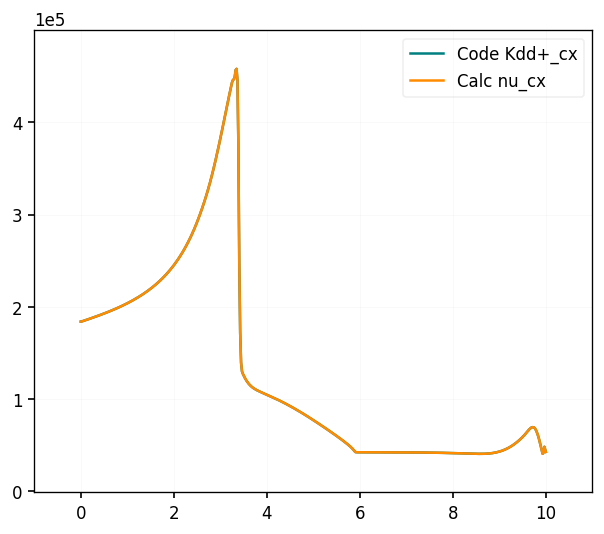

In [10]:
ds = cs["base"].ds.isel(t=-1)
m = ds.metadata

Ta = ds["Td"].values
Ti = ds["Td+"].values
Ne = ds["Ne"].values

ln_sigmav = -18.5028
Teff = (Ta + Ti)/2
lnT = np.log(Teff)
lnT_n = lnT.copy()

for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
    ln_sigmav += b * lnT_n
    lnT_n *= lnT
    
nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s to 1/s

fig, ax = plt.subplots()
dist = ds["pos"].values


ax.plot(dist, ds["Kdd+_cx"], label = "Code Kdd+_cx")
ax.plot(dist, nu_cx, label = "Calc nu_cx")

ax.legend()
# ds["Kdd+_cx"].plot()

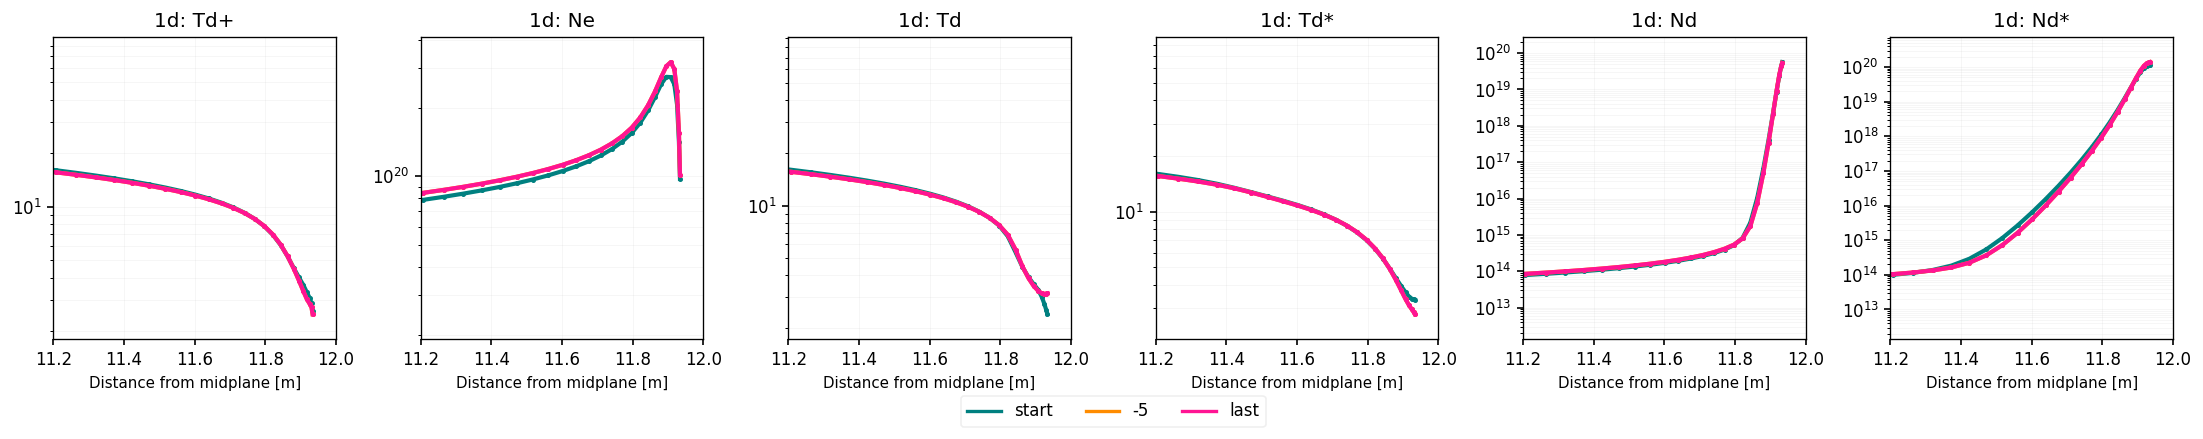

In [4]:
case = "neutbc"
lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-5":cs[case].ds.isel(t=-5),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Ne", "Td", "Td*", "Nd", "Nd*"],
    regions = ["1d"],
    xlims=(11.2,12)
)

In [5]:
cs["neutbc"].ds["Sdd*_refl"].isel(t=-1).values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [23]:
ds["Sdd*_refl"].values

array([], dtype=float64)

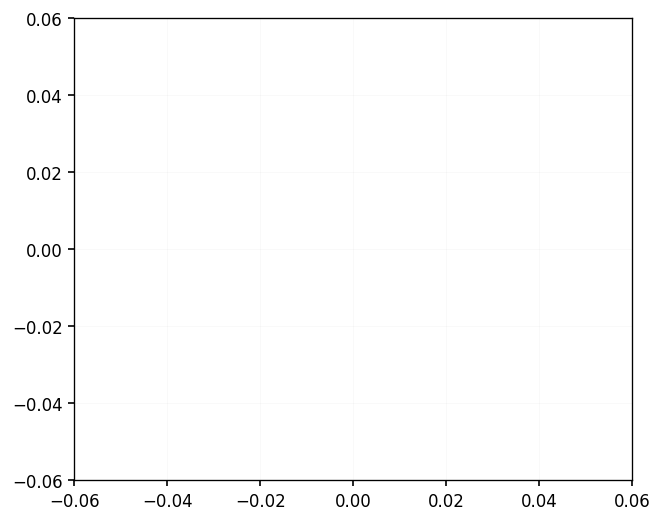

In [22]:
ds = cs["neutbc"].ds.isel(t=-1, pos = slice(2-2))

fig, ax = plt.subplots()
pos = ds["pos"].values
ax.plot(pos, ds["Sdd*_refl"].values, label="Sdd*_refl")

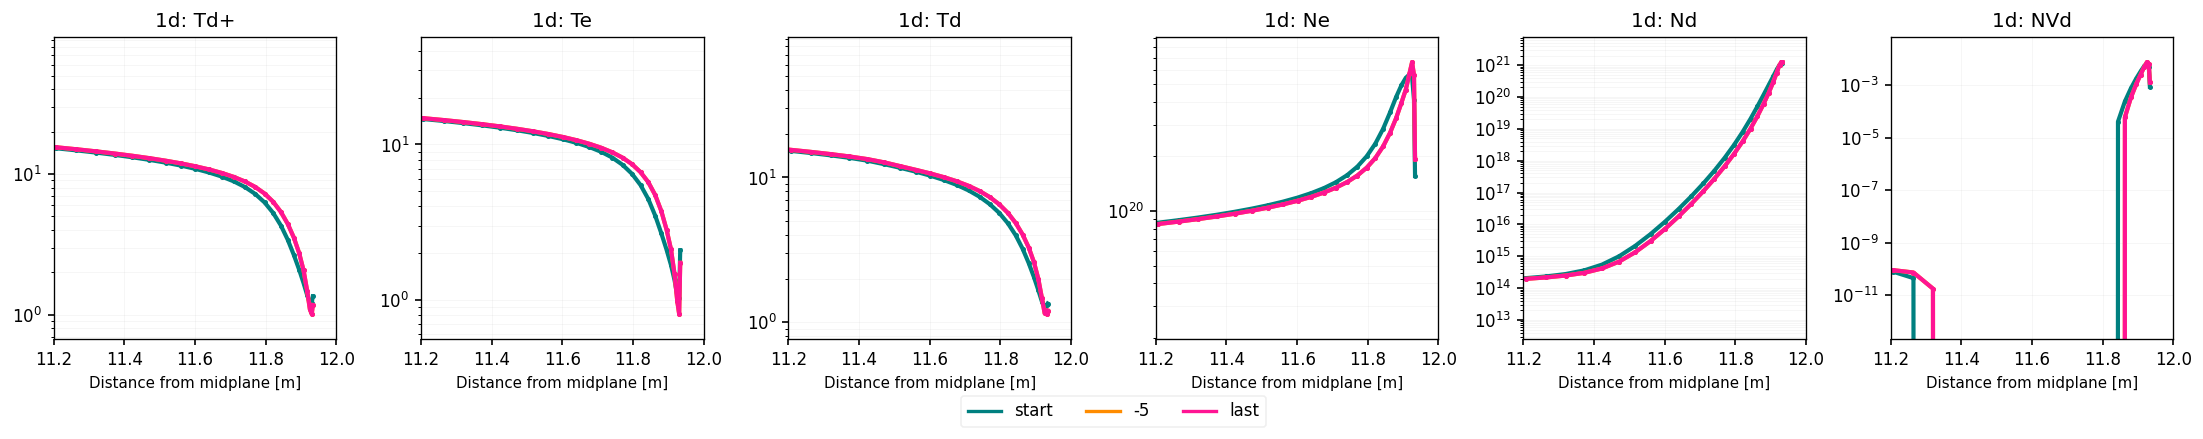

In [5]:
case = "nbound"
lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-5":cs[case].ds.isel(t=-5),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd"],
    regions = ["1d"],
    xlims=(11.2,12)
)

In [12]:
ds = cs["nbound"].ds.isel(t=-1, pos = slice(2,-2))
(ds["Ed_target_refl"]*ds["dv"]).sum("pos").values

array(2.34081745e+15)

(10.0, 12.0)

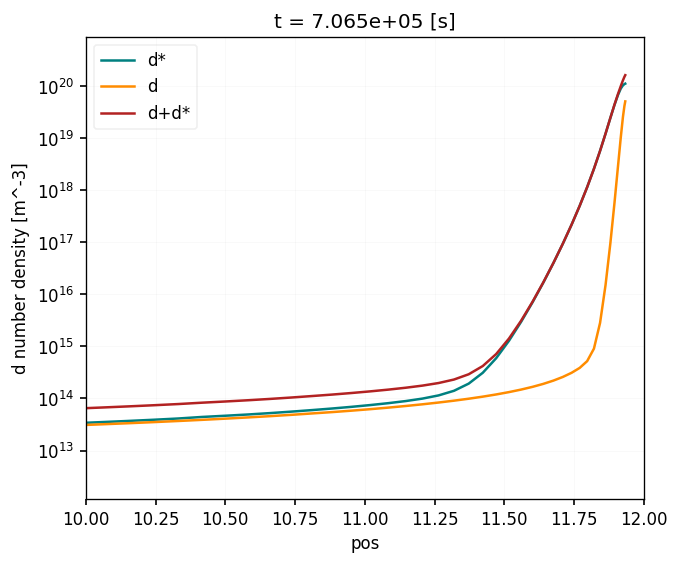

In [6]:
ds = cs["neutbc"].ds.isel( pos = slice(2,-2))
if "t" in ds.dims: ds = ds.isel(t=10)

fig, ax = plt.subplots()
ds["Nd*"].plot(ax = ax, label = "d*")
ds["Nd"].plot(ax = ax, label = "d")
(ds["Nd"] + ds["Nd*"]).plot(ax = ax, label = "d+d*")

ax.set_yscale("symlog")
ax.legend()
ax.set_xlim(10,12)
# ax.set_xscale("symlog")
# ds["Sd*d+_iz"].plot()

In [21]:
addvar("NVd", 0, r"/ssd_scratch/hcases/hotneut/hn1b-add_NVn")

Number of restart files: 4
/ssd_scratch/hcases/hotneut/hn1b-add_NVn/BOUT.restart.1.nc
/ssd_scratch/hcases/hotneut/hn1b-add_NVn/BOUT.restart.3.nc
/ssd_scratch/hcases/hotneut/hn1b-add_NVn/BOUT.restart.2.nc
/ssd_scratch/hcases/hotneut/hn1b-add_NVn/BOUT.restart.0.nc


In [11]:
tnsheath = 0.5
nnsheath = 1e10
v_th = np.sqrt(tnsheath)
alpha = 0.5
R = 0.5

q = (1-alpha*R)-(1-R)*(3/(2*tnsheath))
q

-0.75

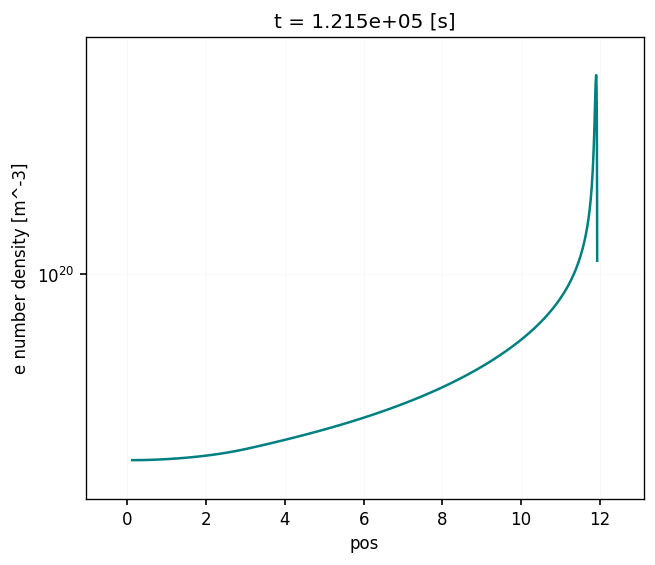

In [6]:
fig, ax = plt.subplots()
ds["Ne"].plot(ax = ax, label = "d sink CXT")
# ds["Sdd+_iz"].plot(ax = ax, label = "d* IZ")

ax.set_yscale("symlog")

In [43]:
ds["Sdd+_iz"].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [18]:
c = {}
c["target"] = ds["Sd_target_recycle"].values.sum()
c["cxt"] = ds["Sd*d+_cxt"].values.sum() * -1   # Source of d* (sink of d)
c["iz"] = ds["Sdd+_iz"].values.sum() * -1  # Source of d+ (sink of d)
c["rec"] = ds["Sd+_rec"].values.sum() * -1  # Sink of d+ (source of d)

print("- Sources for d:")
for param in c:
    print(f'{param}: {c[param]:.3e}')

h = {}
# h["cxt"] = ds["Sd*_target_recycle"].values.sum()
h["cxt"] = ds["Sd*d+_cxt"].values.sum()   # Source of d* (sink of d)
h["iz"] = ds["Sd*d+_iz"].values.sum()  * -1   # Source of ions (sink of neutrals)

print("\n- Sources for d*:")
for param in h:
    print(f'{param}: {h[param]:.3e}')

- Sources for d:
target: 1.326e+26
cxt: -2.261e+27
iz: -1.124e+16
rec: 9.759e+22

- Sources for d*:
cxt: 2.261e+27
iz: -2.173e+25


# Check CX rate

In [47]:
def get_cx(Ta, Ti, Ne):
    ln_sigmav = -18.5028
    Teff = (Ta + Ti)/2
    lnT = np.log(Teff)
    lnT_n = lnT.copy()

    for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
        ln_sigmav += b * lnT_n
        lnT_n *= lnT
        
    nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s
    
    return nu_cx

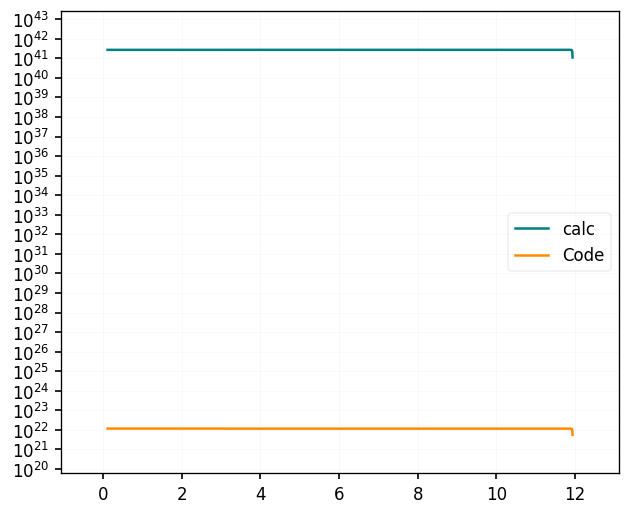

In [63]:
nu_cx = get_cx(ds["Td"], ds["Td+"], ds["Ne"]).values
K_cx = nu_cx * ds["Nd"] * ds["Nd+"]

fig, ax = plt.subplots()
pos = ds["pos"]

ax.plot(pos, K_cx, label = "calc")
ax.plot(pos, ds["Sd*d+_cxt"], label = "Code")

ax.legend()
ax.set_yscale("symlog")
# K_cx.values

In [51]:
ds["Sd"]

array([2.11688563, 2.11688563, 2.11688563, 2.11688563, 2.11688563,
       2.11688563, 2.11688563, 2.11688563, 2.11688563, 2.11688563,
       2.11688563, 2.11688564, 2.11687781, 2.11461719, 2.00335851,
       2.00105788, 2.00104978, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104979,
       2.00104979, 2.00104979, 2.00104979, 2.00104979, 2.00104

# Charge exchange

(11.5, 12.0)

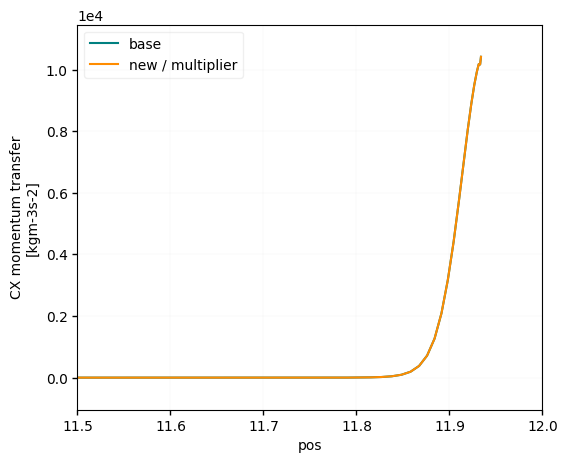

In [5]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Fdd+_cx"].plot(ax = ax, label = "base")
(new["Fdd+_cx"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.5, 12.0)


# Fixed fraction impurity radiation

(11.5, 12.0)

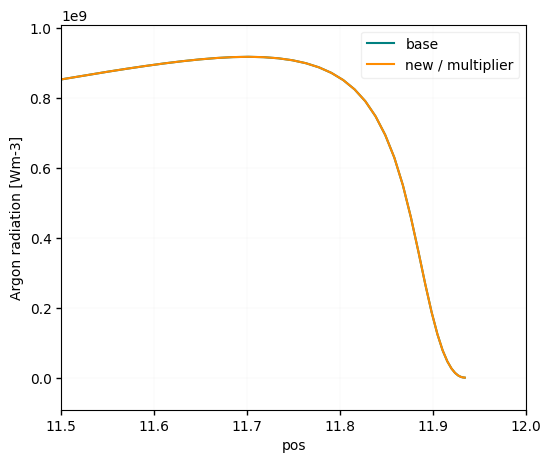

In [6]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Rar"].plot(ax = ax, label = "base")
(new["Rar"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.5, 12.0)


# Ionisation

(11.8, 12.0)

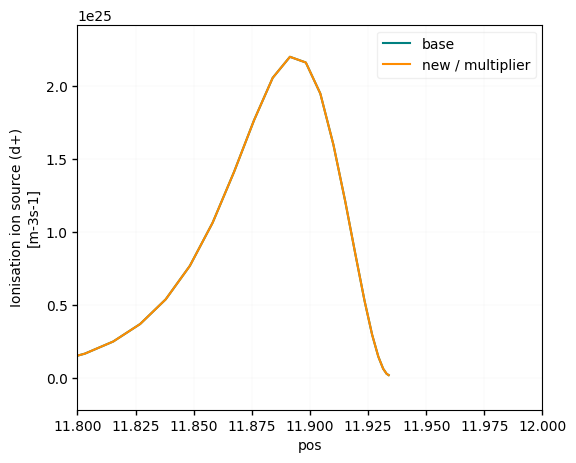

In [7]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Sd+_iz"].plot(ax = ax, label = "base")
(new["Sd+_iz"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.8, 12.0)


# Recombination

(11.8, 12.0)

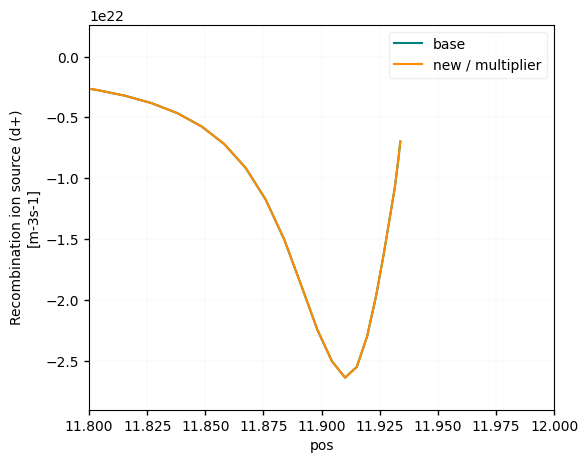

In [8]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Sd+_rec"].plot(ax = ax, label = "base")
(new["Sd+_rec"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.8, 12.0)


# Ionisation radiation

(11.8, 12.0)

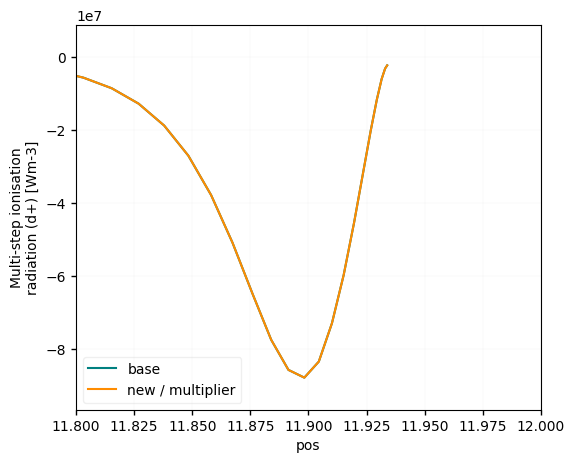

In [9]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Rd+_ex"].plot(ax = ax, label = "base")
(new["Rd+_ex"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.8, 12.0)


# Recombination radiation

(11.8, 12.0)

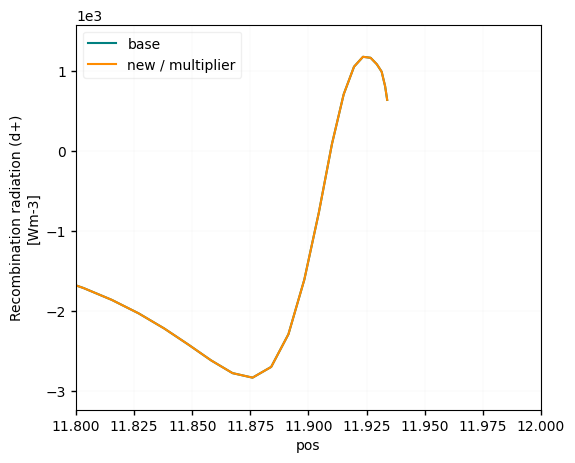

In [10]:
fig, ax = plt.subplots(dpi = 100)

base = casestore["base"].ds.isel(pos=slice(2,-2))
new = casestore["new"].ds.isel(pos=slice(2,-2))

base["Rd+_rec"].plot(ax = ax, label = "base")
(new["Rd+_rec"]/0.9).plot(ax = ax, label = "new / multiplier")
ax.legend()

ax.set_xlim(11.8, 12.0)
